In [ ]:
#Part 3 - Using the latent space now and referring to the work in paper, discover the symmetries in the MNIST dataset created
#earlier that preserve the logit. Rotation should be one of the discovered symmetries.


import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate

# Just creating the dataset
rotation_angles = [30 * i for i in range(12)]  # 0 to 330 degrees
selected_digits = {1, 2}  # Use only digits 1 and 2

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Filter for digits 1 and 2
dataset_filtered = [(image, label) for image, label in mnist_dataset if label in selected_digits]

# Rotate dataset
def rotate_dataset(dataset, angles):
    rotated_dataset = []
    for image, label in dataset:
        for angle in angles:
            rotated_image = rotate(image, angle)
            rotated_dataset.append((rotated_image, label))
    return rotated_dataset

rotated_dataset = rotate_dataset(dataset_filtered, rotation_angles)

# Shuffling dataset
np.random.shuffle(rotated_dataset)

# Convert dataset to numpy arrays
images, labels = zip(*rotated_dataset)
images = np.array([img.numpy().flatten() for img in images])
labels = np.array([0 if label == 1 else 1 for label in labels])  # Map labels: 1 -> 0, 2 -> 1

# Convert to PyTorch tensors
x_train = torch.tensor(images, dtype=torch.float32)
y_train = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Encoder Network
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.decoder(z)

# Induced classifier \psi (z → y)
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(x)

# Direct classifier (x → y)
class DirectClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DirectClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(x)

# Symmetry Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, z):
        return self.generator(z)

# Define loss functions
def mse_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def normalization_loss(GW_xi):
    return torch.mean(torch.norm(GW_xi, dim=1) - 1) ** 2

def invariance_loss(encoder, classifier, generator, x, targets):
    epsilon = 1e-3
    z = encoder(x)
    GW_xi = generator(z)
    z_transformed = z + epsilon * GW_xi
    class_pred = classifier(z_transformed)
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=2).float()
    return mse_loss(class_pred, targets_one_hot)

# Training setup
input_dim = 784  # Flattened image size
latent_dim = 4  # Reduced dimensionality
output_dim = 2  # Digits 1 and 2

encoder = Encoder(input_dim, latent_dim)
decoder = Decoder(latent_dim, input_dim)
classifier = Classifier(latent_dim, output_dim)
direct_classifier = DirectClassifier(input_dim, output_dim)
generator = Generator(latent_dim)

optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) +
    list(classifier.parameters()) + list(direct_classifier.parameters()) +
    list(generator.parameters()), lr=0.001
)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()

        z = encoder(x_batch)
        x_recon = decoder(z)
        class_pred = classifier(z)
        direct_class_pred = direct_classifier(x_batch)

        mse = mse_loss(x_recon, x_batch)
        norm_loss = normalization_loss(generator(z))
        ce_loss = torch.nn.functional.cross_entropy(class_pred, y_batch)
        direct_ce_loss = torch.nn.functional.cross_entropy(direct_class_pred, y_batch)
        inv_loss = invariance_loss(encoder, classifier, generator, x_batch, y_batch)

        loss = mse + norm_loss + ce_loss + direct_ce_loss + inv_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/30, Loss: 0.7109
Epoch 2/30, Loss: 0.6858
Epoch 3/30, Loss: 0.6803
Epoch 4/30, Loss: 0.6773
Epoch 5/30, Loss: 0.6743
Epoch 6/30, Loss: 0.6720
Epoch 7/30, Loss: 0.6699
Epoch 8/30, Loss: 0.6689
Epoch 9/30, Loss: 0.6675
Epoch 10/30, Loss: 0.6658
Epoch 11/30, Loss: 0.6649
Epoch 12/30, Loss: 0.6644
Epoch 13/30, Loss: 0.6642
Epoch 14/30, Loss: 0.6636
Epoch 15/30, Loss: 0.6627
Epoch 16/30, Loss: 0.6625
Epoch 17/30, Loss: 0.6619
Epoch 18/30, Loss: 0.6616
Epoch 19/30, Loss: 0.6614
Epoch 20/30, Loss: 0.6606
Epoch 21/30, Loss: 0.6608
Epoch 22/30, Loss: 0.6608
Epoch 23/30, Loss: 0.6610
Epoch 24/30, Loss: 0.6608
Epoch 25/30, Loss: 0.6603
Epoch 26/30, Loss: 0.6597
Epoch 27/30, Loss: 0.6598
Epoch 28/30, Loss: 0.6596
Epoch 29/30, Loss: 0.6590
Epoch 30/30, Loss: 0.6597


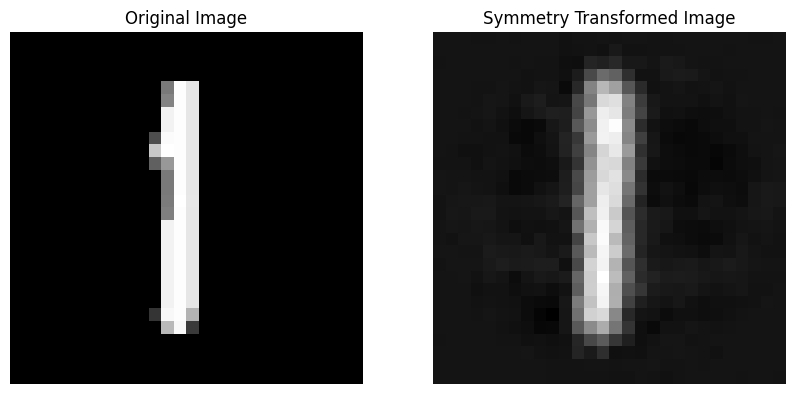

In [ ]:
#Showing what symmetries are obtained
with torch.no_grad():
    test_image = x_train[57].unsqueeze(0)  # Add batch dimension

    z = encoder(test_image)
    z_transformed = z + generator(z)
    transformed_image = decoder(z_transformed).view(28, 28)
    original_image = test_image.view(28, 28)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(transformed_image, cmap='gray')
    axs[1].set_title("Symmetry Transformed Image")
    axs[1].axis('off')

    plt.show()

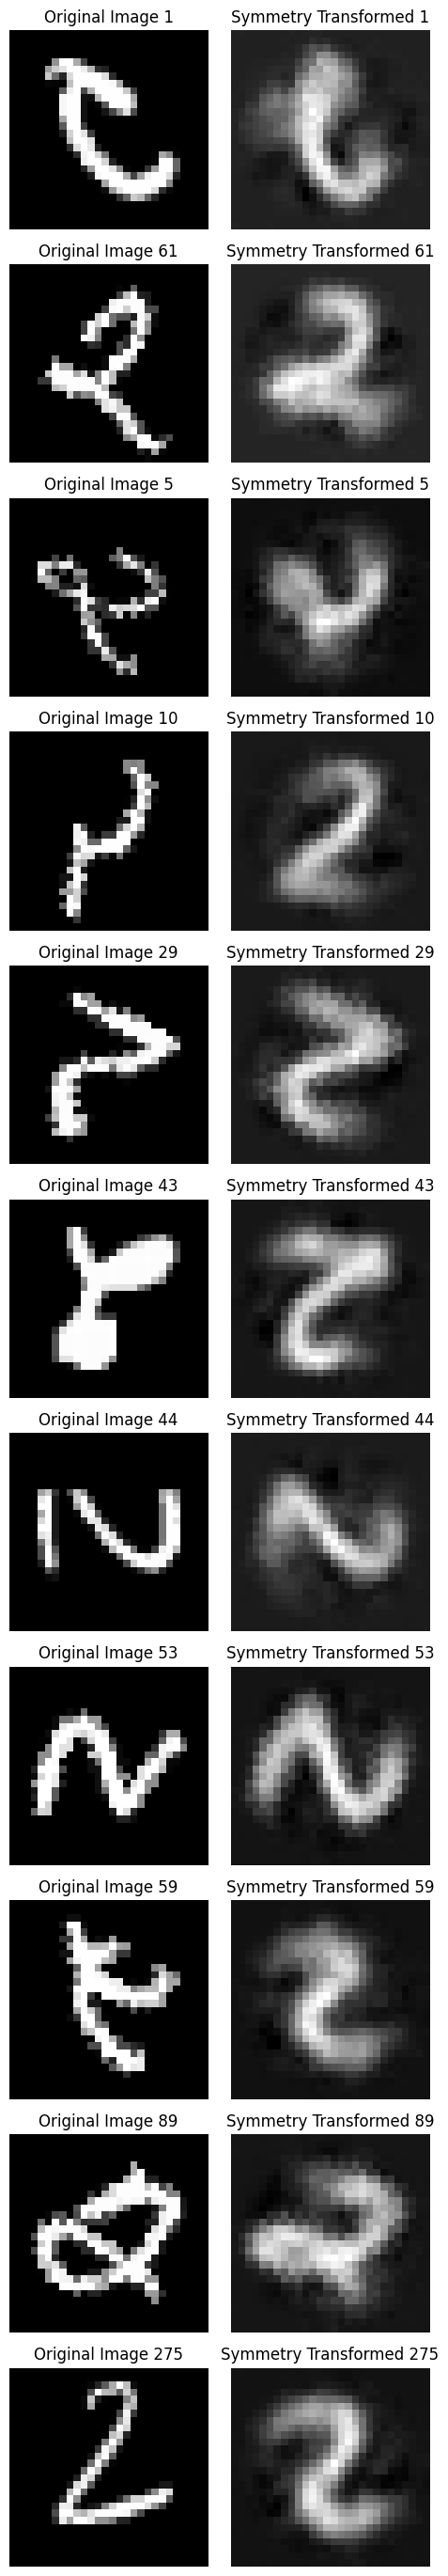

In [ ]:
# Symmetry discovered in rotation examples

import torch
import matplotlib.pyplot as plt
import random

  # Number of images to visualize
indices = [1,61,5,10,29,43,44,53,59,89,275]  # Randomly select indices
num_images = len(indices)

fig, axs = plt.subplots(num_images, 2, figsize=(5, num_images * 2.5))

with torch.no_grad():
    for i, idx in enumerate(indices):
        test_image = x_train[idx].unsqueeze(0)  # Add batch dimension

        z = encoder(test_image)
        z_transformed = z + generator(z)
        transformed_image = decoder(z_transformed).view(28, 28)
        original_image = test_image.view(28, 28)

        axs[i, 0].imshow(original_image, cmap='gray')
        axs[i, 0].set_title(f"Original Image {idx}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(transformed_image, cmap='gray')
        axs[i, 1].set_title(f"Symmetry Transformed {idx}")
        axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


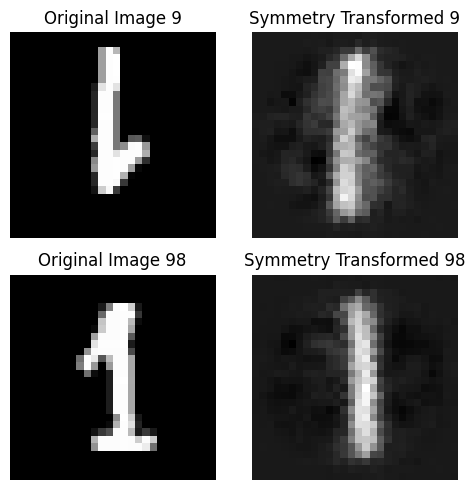

In [ ]:
# Symmetry discovered in removing the upper dash on the digit 1

import torch
import matplotlib.pyplot as plt
import random

  # Number of images to visualize
indices = [9,98]  # Randomly select indices
num_images = len(indices)

fig, axs = plt.subplots(num_images, 2, figsize=(5, num_images * 2.5))

with torch.no_grad():
    for i, idx in enumerate(indices):
        test_image = x_train[idx].unsqueeze(0)  # Add batch dimension

        z = encoder(test_image)
        z_transformed = z + generator(z)
        transformed_image = decoder(z_transformed).view(28, 28)
        original_image = test_image.view(28, 28)

        axs[i, 0].imshow(original_image, cmap='gray')
        axs[i, 0].set_title(f"Original Image {idx}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(transformed_image, cmap='gray')
        axs[i, 1].set_title(f"Symmetry Transformed {idx}")
        axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


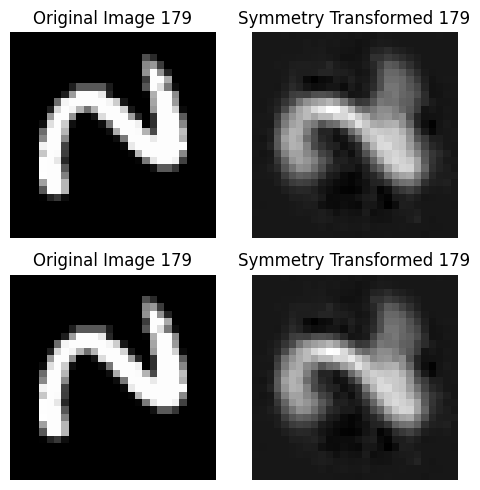

In [ ]:
# Symmetry discovered in putting the cursive type of 2, an upper curl downwards

import torch
import matplotlib.pyplot as plt
import random

  # Number of images to visualize
indices = [179,179]  # Randomly select indices
num_images = len(indices)

fig, axs = plt.subplots(num_images, 2, figsize=(5, num_images * 2.5))

with torch.no_grad():
    for i, idx in enumerate(indices):
        test_image = x_train[idx].unsqueeze(0)  # Add batch dimension

        z = encoder(test_image)
        z_transformed = z + generator(z)
        transformed_image = decoder(z_transformed).view(28, 28)
        original_image = test_image.view(28, 28)

        axs[i, 0].imshow(original_image, cmap='gray')
        axs[i, 0].set_title(f"Original Image {idx}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(transformed_image, cmap='gray')
        axs[i, 1].set_title(f"Symmetry Transformed {idx}")
        axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


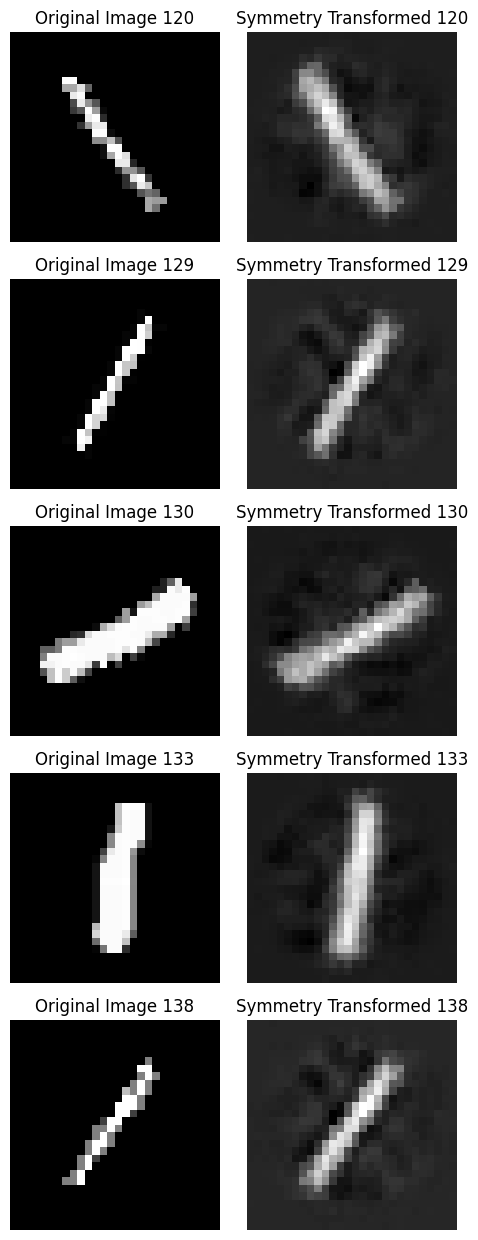

In [ ]:
# Elongating and shrinking digit 1's

import torch
import matplotlib.pyplot as plt
import random

  # Number of images to visualize
indices = [120,129,130,133,138]  # Randomly select indices
num_images = len(indices)

fig, axs = plt.subplots(num_images, 2, figsize=(5, num_images * 2.5))

with torch.no_grad():
    for i, idx in enumerate(indices):
        test_image = x_train[idx].unsqueeze(0)  # Add batch dimension

        z = encoder(test_image)
        z_transformed = z + generator(z)
        transformed_image = decoder(z_transformed).view(28, 28)
        original_image = test_image.view(28, 28)

        axs[i, 0].imshow(original_image, cmap='gray')
        axs[i, 0].set_title(f"Original Image {idx}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(transformed_image, cmap='gray')
        axs[i, 1].set_title(f"Symmetry Transformed {idx}")
        axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
